# Project 2: Wrangling and Analyze Data

## Table of Contents
<ul>
<li><a href="#intro">1. Introduction</a></li>
<li><a href="#wrangling">2. Data Wrangling</a></li>
<li><a href="#eda">3. Exploratory Data Analysis</a></li>
<li><a href="#conclusions">4. Conclusions</a></li>
<li><a href="#references">5. References</a></li>
</ul>

<a id='intro'></a>
## Introduction

> This project seeks to explore and better understand data wragling. In this project, data is gathered from a variety of sources and in a variety of formats, assessed and tidied, then cleaned. 
>The goal is to wrangle WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations.
>The project uses three (3) datasets;
>1. The Enhanced Twitter Archive, 2. Additional Data via the Twitter API and 3. Image Predictions File

The dataset used is the tweet archive of Twitter user @dog_rates, also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc. Why? Because "they're good dogs Brent." WeRateDogs has over 4 million followers and has received international media coverage.

In [160]:
# we import all packages that we need
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import tweepy
import json
import os
import re
import warnings
warnings.simplefilter('ignore')

<a id='wrangling'></a>
## Data Wrangling

##  Data Gathering


In [161]:
# read the twitter_archive_enhanced.csv into twitter_archive dataframe
twitter_archive = pd.read_csv('./input/twitter-archive-enhanced.csv')

In [162]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [6]:
# define function to download file 
def download_file_with_requests(folder_name, url):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
        
    response = requests.get(url, allow_redirects=True)
    
    # extract file name from url and use it to save the file
    file_name = url.rsplit('/', 1)[1]
    with open(os.path.join(folder_name, file_name), mode='wb') as file:
        file.write(response.content)

In [7]:
# download the image_predictions.tsv data using the function above into the downloads folder
folder_name = 'downloads'
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

download_file_with_requests(folder_name, url)

In [163]:
# read the downloaded image-predictions.tsv file into a new pandas dataframe
image_predictions = pd.read_csv('./downloads/image-predictions.tsv', sep='\t')


In [164]:
image_predictions.info()      

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [165]:
from tweepy import OAuthHandler
from timeit import default_timer as timer

In [12]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

tweet_ids = twitter_archive.tweet_id.values
len(tweet_ids)

2356

In [13]:
# function to extract tweet data... 
# note: the code below is provided by udacity
def tweet_extraction():
    folder_name = 'downloads'
    count = 0
    fails_dict = {}
    start = timer()
    with open(os.path.join(folder_name, 'tweet_json.txt'), 'w') as outfile:
        for tweet_id in tweet_ids:
            count += 1
            print(str(count) + ": " + str(tweet_id))
            try:
                tweet = api.get_status(tweet_id, tweet_mode='extended')
                print("Success")
                json.dump(tweet._json, outfile)
                outfile.write('\n')
            except tweepy.TweepError as e:
                print("Fail")
                fails_dict[tweet_id] = e
                pass
    end = timer()
    print(end - start)
    print(fails_dict)

> Read tweet_json.txt into a pd dataframe line by line with key columns as tweet_ID, retweet_count and favorite_count

In [166]:
tweet_json_list_df = []
with open('./downloads/tweet_json.txt') as file:
    for line in file:
        data = json.loads(line)
        keys = data.keys()
        user = data.get('user')
        id_str = data.get('id_str')
        retweet_count = data.get('retweet_count')
        favorite_count = data.get('favorite_count')
        tweet_json_list_df.append(
            {'id_str': id_str, 'retweet_count': retweet_count, 'favorite_count': favorite_count})

tweet_json = pd.DataFrame(tweet_json_list_df , columns = ['id_str', 'retweet_count', 'favorite_count'])

In [167]:
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id_str          2354 non-null   object
 1   retweet_count   2354 non-null   int64 
 2   favorite_count  2354 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 55.3+ KB


## Assessing Data




### Visuals

In [168]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

> 1. Missing values ie 'NaN' in the following columns: <b>in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, and expanded_urls </b>.<br/>
> 2. There are 181 retweets, we need to remove them
> 3. Column name <b>'floofer'</b> should be correctly spelled <b>'floof'</b>

In [169]:
twitter_archive.text[0]


"This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU"

In [170]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [171]:
tweet_json.head()

id_str  retweet_count  favorite_count
0  892420643555336193           8853           39467
1  892177421306343426           6514           33819
2  891815181378084864           4328           25461
3  891689557279858688           8964           42908
4  891327558926688256           9774           41048

### Programatic

In [172]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

><b>tweet_id</b> has dtype int64 and should be object not integers or floats because they are not numeric and aren't intended to perform calculations.<br/>
><b>timestamp</b> should be a datetime64 dtype type as well

### Quality issues
<b>`twitter_archive`</b> table

1. Only original tweets with images are needed. Thus we remove from table retweets and replies.
2. Missing values i.e. 'NaN' in the following columns: <b>in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, and expanded_urls </b>.
3. <b>timestamp</b> should be changed from object to datetime
4. <b>tweet_id</b> has dtype int64 and should be string
5. <b>timestamp</b> should be a changed to datetime64 type
6. The source column in `twitter_archive` table looks messy and clutters the table.
7. Incorrect extraction of `ratings` from the <b>text</b> column. Ratings with decimal values incorrectly extracted 
8. Combine <b>rating_denominator</b> and <b>rating_numerator</b> columns into <b>dog_rating</b> column
9. Include only tweets with images, thus drop tweets with NaN in expanded_urls



<b>`image_predictions`</b> table
1. The <b>tweet_id</b> column should be of type string instead of int64.
2. The types of dogs in columns <b>p1</b>, <b>p2</b>, and <b>p3</b> had a mix of uppercase and lowercase letters. Need to change to lowercase


<b>`tweet_json`</b> table
1. Keep original tweets only
2. The column <b>'id_str'</b> should be changed to <b>'tweet_id'</b> so it can be consistent with tweeter_archive and image_prediction dataframes



### Tidiness issues

1. There are multiple dog stages columns present e.g. doggo, pupper, etc. They should be merged into 1 column
2. All three tables `twitter_archive`, `image_predictions` and `tweet_json` should be be merged into one.

## Cleaning Data


In [270]:
# Make copies of original pieces of data
archive_clean = twitter_archive.copy()
predictions_clean = image_predictions.copy()
tweet_clean = tweet_json.copy()

### Issue #1: Keep only original tweets 

#### Define:
>Only original tweets with images are needed. Thus we remove from `twitter_archive` table retweets and replies.

#### Code

In [271]:
# Filter by columns; 'in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp' , and delete them
deleted_columns = ['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id',
        'retweeted_status_user_id', 'retweeted_status_timestamp']

for col in deleted_columns:
    archive_clean = archive_clean[archive_clean[col].isnull()]
    archive_clean = archive_clean.drop([col], axis = 1)
    

#### Test

In [272]:
# we should only have 2097 columns and with the cols deleted
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2097 non-null   int64 
 1   timestamp           2097 non-null   object
 2   source              2097 non-null   object
 3   text                2097 non-null   object
 4   expanded_urls       2094 non-null   object
 5   rating_numerator    2097 non-null   int64 
 6   rating_denominator  2097 non-null   int64 
 7   name                2097 non-null   object
 8   doggo               2097 non-null   object
 9   floofer             2097 non-null   object
 10  pupper              2097 non-null   object
 11  puppo               2097 non-null   object
dtypes: int64(3), object(9)
memory usage: 213.0+ KB


### Issue #2: Remove irrelevant columns NaN 

#### Define
>Missing values i.e. 'NaN' in the following columns in `twitter_archive` table: in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, and expanded_urls .

This has been taken care of by the code in Issue #1 aboove

#### Test

In [273]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2097 non-null   int64 
 1   timestamp           2097 non-null   object
 2   source              2097 non-null   object
 3   text                2097 non-null   object
 4   expanded_urls       2094 non-null   object
 5   rating_numerator    2097 non-null   int64 
 6   rating_denominator  2097 non-null   int64 
 7   name                2097 non-null   object
 8   doggo               2097 non-null   object
 9   floofer             2097 non-null   object
 10  pupper              2097 non-null   object
 11  puppo               2097 non-null   object
dtypes: int64(3), object(9)
memory usage: 213.0+ KB


### Issue #3: Fixing Inconsistent Column names and thier Datatypes

#### Define
>Change <b>timestamp</b> column in `archive_clean` dataframe from object to datetime<br/>
>Change <b>tweet_id</b> column in `predictions_clean` dataframe from object to string<br/>
>Rename <b>id_str</b> col into <b>tweet_id</b> in `tweet_clean` dataframe from object to string<br/>
>Change <b>tweet_id</b> column in `tweet_clean` dataframe from object to string<br/>

### Code

In [274]:
archive_clean.timestamp = pd.to_datetime(archive_clean.timestamp)
archive_clean.tweet_id = archive_clean.tweet_id.astype('str')
predictions_clean.tweet_id = predictions_clean.tweet_id.astype('str')
tweet_clean.rename(index=str, columns={"id_str": "tweet_id"}, inplace=True)
tweet_clean.tweet_id = tweet_clean.tweet_id.astype('str')


### Test

In [275]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2097 non-null   object             
 1   timestamp           2097 non-null   datetime64[ns, UTC]
 2   source              2097 non-null   object             
 3   text                2097 non-null   object             
 4   expanded_urls       2094 non-null   object             
 5   rating_numerator    2097 non-null   int64              
 6   rating_denominator  2097 non-null   int64              
 7   name                2097 non-null   object             
 8   doggo               2097 non-null   object             
 9   floofer             2097 non-null   object             
 10  pupper              2097 non-null   object             
 11  puppo               2097 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(2

In [276]:
predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   object 
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


In [277]:
tweet_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2354 non-null   object
 1   retweet_count   2354 non-null   int64 
 2   favorite_count  2354 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 73.6+ KB


### Issue #4: Uniform and Consitent dogbreed names

#### Define
>Change all dogbreed values in cols p1, p2 and p3 in the `predictions_clean` table to lower cases for uniformity

### Code

In [278]:
for col in ['p1', 'p2','p3']:
    predictions_clean[col] = predictions_clean[col].str.lower()

### Test

In [279]:
predictions_clean['p1'].sample(5)

1001      pomeranian
272         scorpion
1099      rottweiler
1131    newfoundland
930     hippopotamus
Name: p1, dtype: object

In [280]:
predictions_clean['p2'].sample(5)

1023         lhasa
563       doberman
1391        basset
375     pomeranian
935      turnstile
Name: p2, dtype: object

In [281]:
predictions_clean['p3'].sample(5)

2036                   chihuahua
1464                      beagle
1903    chesapeake_bay_retriever
1595             norfolk_terrier
1237                    cardigan
Name: p3, dtype: object

### Issue #5: Messy Source Column in archive_clean table

### Define
>Use regex to extract the source (Twitter for iPhone, Twitter Web Client, or TweetDeck) from source column in `archive_clean` table

### Code

In [282]:
archive_clean.source = archive_clean.source.str.extract(r"(?<=>)(.*)(?=<)")

### Test

In [283]:
archive_clean.source.unique()

array(['Twitter for iPhone', 'Twitter Web Client', 'Vine - Make a Scene',
       'TweetDeck'], dtype=object)

### Issue #6: Accurate Rating Extraction

### Define
> Ratings with decimal values incorrectly extracted <br/>
> The rating_numerator column should be of type float and also it should be correctly extracted from the text <br/>
> Then, rating_numerator and rating_denominator should be combined to dog_rating i.e. rating_numerator/rating_denominator * 100

### Code

In [284]:
archive_clean['rating_numerator'] = archive_clean['rating_numerator'].astype('float64')

In [285]:
rating_numerators = archive_clean.text.str.extract('((?:\d+\.)?\d+)\/(\d+)', expand=True)[0].astype('float64')

In [286]:
archive_clean['rating_numerator'] = rating_numerators

### Test

In [287]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2097 non-null   object             
 1   timestamp           2097 non-null   datetime64[ns, UTC]
 2   source              2097 non-null   object             
 3   text                2097 non-null   object             
 4   expanded_urls       2094 non-null   object             
 5   rating_numerator    2097 non-null   float64            
 6   rating_denominator  2097 non-null   int64              
 7   name                2097 non-null   object             
 8   doggo               2097 non-null   object             
 9   floofer             2097 non-null   object             
 10  pupper              2097 non-null   object             
 11  puppo               2097 non-null   object             
dtypes: datetime64[ns, UTC](1), float64

In [288]:
# extract all rating_numerators from the text columns and compare with rating_numerator column

rating_num_from_text = archive_clean.text.str.extract('((?:\d+\.)?\d+)\/(\d+)', expand=True)[0].astype('float64')
rating_num_from_text.equals(archive_clean['rating_numerator'])

True

### Issue #7: Combine rating_numerator and rating_denominator columns into dog_rating column

### Define
> rating_numerator/rating_denominator * 100

### Code

In [289]:
archive_clean['dog_rating'] = 100*(archive_clean['rating_numerator']/archive_clean['rating_denominator'])

In [290]:
# drop rating_numerator and rating_denominator columns
archive_clean = archive_clean.drop(['rating_numerator', 'rating_denominator'], axis=1)

### Test

In [291]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   tweet_id       2097 non-null   object             
 1   timestamp      2097 non-null   datetime64[ns, UTC]
 2   source         2097 non-null   object             
 3   text           2097 non-null   object             
 4   expanded_urls  2094 non-null   object             
 5   name           2097 non-null   object             
 6   doggo          2097 non-null   object             
 7   floofer        2097 non-null   object             
 8   pupper         2097 non-null   object             
 9   puppo          2097 non-null   object             
 10  dog_rating     2097 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(1), object(9)
memory usage: 196.6+ KB


### Issue #8: Include only tweets with images, thus drop tweets with NaN in expanded_urls

### Define
> Drop tweets with NaN in expanded_url colums

### Code

In [292]:
archive_clean = archive_clean[archive_clean['expanded_urls'].notna()]

### Test

In [293]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   tweet_id       2094 non-null   object             
 1   timestamp      2094 non-null   datetime64[ns, UTC]
 2   source         2094 non-null   object             
 3   text           2094 non-null   object             
 4   expanded_urls  2094 non-null   object             
 5   name           2094 non-null   object             
 6   doggo          2094 non-null   object             
 7   floofer        2094 non-null   object             
 8   pupper         2094 non-null   object             
 9   puppo          2094 non-null   object             
 10  dog_rating     2094 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(1), object(9)
memory usage: 196.3+ KB


### Issue #9: Dog stages should be merged into 1 column

### Define 
> There are multiple dog stages columns present e.g. doggo, pupper, etc. They should be merged into 1 column <br/>
> - Set the None values to np.nan in all the 4 dog stage columns.<br/>
> - Concatenate all 4 columns to 1 column dog_stage <br/>
> - Now the multiple dog stages rows will have values combined (like doggopupper) . So replace them with code (to doggo,pupper) <br/>
> - Remove the original 4 columns of dog stages. <br/>

### Code

In [294]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   tweet_id       2094 non-null   object             
 1   timestamp      2094 non-null   datetime64[ns, UTC]
 2   source         2094 non-null   object             
 3   text           2094 non-null   object             
 4   expanded_urls  2094 non-null   object             
 5   name           2094 non-null   object             
 6   doggo          2094 non-null   object             
 7   floofer        2094 non-null   object             
 8   pupper         2094 non-null   object             
 9   puppo          2094 non-null   object             
 10  dog_rating     2094 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(1), object(9)
memory usage: 196.3+ KB


In [295]:

#loop through the stages and  replace the None in the 4 columns with empty string
for i in ['doggo', 'floofer', 'pupper', 'puppo']:
    archive_clean[i] = archive_clean[i].replace('None', '')

In [296]:
# concatenate all 4 columns into one column names dog_satge
archive_clean['dog_stage'] = archive_clean.doggo + archive_clean.floofer + archive_clean.pupper + archive_clean.puppo

In [297]:
archive_clean['dog_stage'].value_counts()

                1759
pupper           220
doggo             72
puppo             23
floofer            9
doggopupper        9
doggopuppo         1
doggofloofer       1
Name: dog_stage, dtype: int64

In [298]:
# now replace combined names to individual name
archive_clean['dog_stage'] = archive_clean['dog_stage'].replace('doggopupper', 'doggo,pupper')
archive_clean['dog_stage'] = archive_clean['dog_stage'].replace('doggopuppo', 'doggo,puppo')
archive_clean['dog_stage'] = archive_clean['dog_stage'].replace('doggofloofer ', 'doggo,floofer ')

In [299]:
#remove all original dog stage individual columns
archive_clean = archive_clean.drop(['doggo','floofer','pupper','puppo'],axis=1)

### Test

In [300]:
archive_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls', 'name',
       'dog_rating', 'dog_stage'],
      dtype='object')

In [301]:
archive_clean['dog_stage'].value_counts()

                1759
pupper           220
doggo             72
puppo             23
floofer            9
doggo,pupper       9
doggo,puppo        1
doggofloofer       1
Name: dog_stage, dtype: int64

### Issue #8: Merge all 3 tables

### Code

In [302]:
df1 = pd.merge(archive_clean, tweet_clean, on='tweet_id')

In [303]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2093
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   tweet_id        2094 non-null   object             
 1   timestamp       2094 non-null   datetime64[ns, UTC]
 2   source          2094 non-null   object             
 3   text            2094 non-null   object             
 4   expanded_urls   2094 non-null   object             
 5   name            2094 non-null   object             
 6   dog_rating      2094 non-null   float64            
 7   dog_stage       2094 non-null   object             
 8   retweet_count   2094 non-null   int64              
 9   favorite_count  2094 non-null   int64              
dtypes: datetime64[ns, UTC](1), float64(1), int64(2), object(6)
memory usage: 180.0+ KB


In [304]:
twitter_archive_master = pd.merge(df1, predictions_clean, on='tweet_id')

### Test

In [311]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   tweet_id        1971 non-null   object             
 1   timestamp       1971 non-null   datetime64[ns, UTC]
 2   source          1971 non-null   object             
 3   text            1971 non-null   object             
 4   expanded_urls   1971 non-null   object             
 5   name            1971 non-null   object             
 6   dog_rating      1971 non-null   float64            
 7   dog_stage       1971 non-null   object             
 8   retweet_count   1971 non-null   int64              
 9   favorite_count  1971 non-null   int64              
 10  jpg_url         1971 non-null   object             
 11  img_num         1971 non-null   int64              
 12  p1              1971 non-null   object             
 13  p1_conf         1971 non-null   f

## Storing Data


In [312]:
#Store the  dataframe to .csv file
twitter_archive_master.to_csv('twitter_archive_master.csv', index=False)


<a id='eda'></a>
## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [313]:
# read the twitter_archive_master csv file into a new pandas dataframe
twitter_df = pd.read_csv('twitter_archive_master.csv')

In [314]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1971 entries, 0 to 1970
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_id        1971 non-null   int64  
 1   timestamp       1971 non-null   object 
 2   source          1971 non-null   object 
 3   text            1971 non-null   object 
 4   expanded_urls   1971 non-null   object 
 5   name            1971 non-null   object 
 6   dog_rating      1971 non-null   float64
 7   dog_stage       303 non-null    object 
 8   retweet_count   1971 non-null   int64  
 9   favorite_count  1971 non-null   int64  
 10  jpg_url         1971 non-null   object 
 11  img_num         1971 non-null   int64  
 12  p1              1971 non-null   object 
 13  p1_conf         1971 non-null   float64
 14  p1_dog          1971 non-null   bool   
 15  p2              1971 non-null   object 
 16  p2_conf         1971 non-null   float64
 17  p2_dog          1971 non-null   b

In [315]:
#Change timestampe to datetime
twitter_df.timestamp = pd.to_datetime(twitter_df.timestamp)

In [316]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1971 entries, 0 to 1970
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   tweet_id        1971 non-null   int64              
 1   timestamp       1971 non-null   datetime64[ns, UTC]
 2   source          1971 non-null   object             
 3   text            1971 non-null   object             
 4   expanded_urls   1971 non-null   object             
 5   name            1971 non-null   object             
 6   dog_rating      1971 non-null   float64            
 7   dog_stage       303 non-null    object             
 8   retweet_count   1971 non-null   int64              
 9   favorite_count  1971 non-null   int64              
 10  jpg_url         1971 non-null   object             
 11  img_num         1971 non-null   int64              
 12  p1              1971 non-null   object             
 13  p1_conf         1971 non-null   f

### Insights #1

In [317]:
twitter_df.describe()

tweet_id    dog_rating  retweet_count  favorite_count      img_num  \
count  1.971000e+03   1971.000000    1971.000000     1971.000000  1971.000000   
mean   7.360418e+17    116.507413    2784.449518     8949.106545     1.201928   
std    6.752810e+16    408.784876    4697.662893    12267.799790     0.559020   
min    6.660209e+17      0.000000      16.000000       81.000000     1.000000   
25%    6.758656e+17    100.000000     628.500000     1997.000000     1.000000   
50%    7.088343e+17    110.000000    1367.000000     4147.000000     1.000000   
75%    7.880951e+17    120.000000    3239.000000    11402.500000     1.000000   
max    8.924206e+17  17760.000000   79515.000000   132810.000000     4.000000   

           p1_conf       p2_conf       p3_conf  
count  1971.000000  1.971000e+03  1.971000e+03  
mean      0.594558  1.345850e-01  6.016556e-02  
std       0.272126  1.010527e-01  5.094156e-02  
min       0.044333  1.011300e-08  1.740170e-10  
25%       0.363091  5.339800e-02  1.608055e-02  
50%       0.587764  1.173970e-01  4.944380e-02  
75%       0.847827  1.955655e-01  9.153815e-02  
max       1.000000  4.880140e-01  2.734190e-01

> - Some of the dogs have 0/10 rating
> - Every tweet has at least 1 image.

### Insights #2
> Which application is the most used by @WeRateDogs followers?

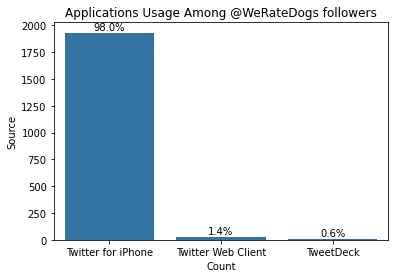

In [318]:
counts = twitter_df.source.value_counts()
total = counts.sum()
max_count = counts[0]
max_prop = max_count / total
tick_props = np.arange(0, max_prop+0.05, 0.05)
tick_names = ['{:0.3f}'.format(v) for v in tick_props]

#Plot Source on x axis and its count on y axis
sns.countplot(data = twitter_df, x = 'source', color = sns.color_palette()[0]);

plt.xlabel("Count");
plt.ylabel("Source");
plt.title('Applications Usage Among @WeRateDogs followers');
locs, labels = plt.xticks(rotation=0)

#Make a loop for each pair of locations and labels
for loc, label in zip(locs, labels):

    # get the text property for the label
    count = counts[label.get_text()]
    pct_string = '{:0.1f}%'.format(100*count/total)

    # print the text on the specified locations
    plt.text(loc, count+2, pct_string, ha = 'center', va = 'bottom', color = 'black')

<b>Twitter for iPhone</b> is the most used application for @WeRateDogs followers

### Insights #3
> Correlation between retweet and ratings

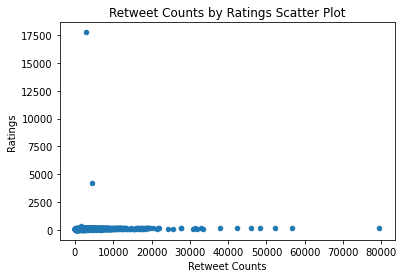

In [319]:
twitter_df.plot(x='retweet_count', y='dog_rating', kind='scatter')
plt.xlabel('Retweet Counts')
plt.ylabel('Ratings')
plt.title('Retweet Counts by Ratings Scatter Plot')

fig = plt.gcf()
fig.savefig('Fig1_Retweet_Counts.png',bbox_inches='tight');

> - The highest dog ratings do not receive the most retweets.

### Insights #4
>What is the time impact on Retweets and Favorite counts?

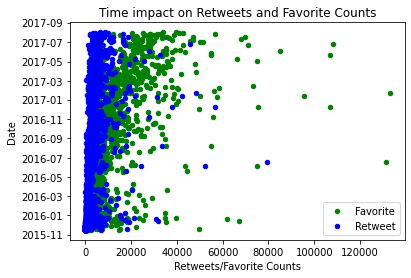

In [320]:
favorites = twitter_df.plot(kind='scatter', y='timestamp', x='favorite_count', color='green')    
retweets = twitter_df.plot(kind='scatter', y='timestamp', x='retweet_count', color='blue', ax=favorites)    


plt.xlabel('Retweets/Favorite Counts')
plt.ylabel('Date')
plt.title('Time impact on Retweets and Favorite Counts')

plt.legend(["Favorite", "Retweet"]);


plt.savefig('Fig4_Time_impact_retweets&fav_counts.png', bbox_inches='tight');

> - Retweets and Favorite Counts appreciates appreciable overtime.
> - The biggest retweet count was about 80,000 in June 2016.

<a id='conclusions'></a>
## Conclusion

> 1. Twitter for iPhone is the most used application for @WeRateDogs followers <br/>
> 2. Retweets and Favorite Counts appreciates appreciable overtime.
> 3. The biggest retweet count was about 80,000 in June 2016.
> 4. Some of the dogs have 0/10 rating
> 5. Every tweet has at least 1 image.
> 6. Retweets and Favorite Counts appreciates appreciable overtime.
> 7. The biggest retweet count was about 80,000 in June 2016.

<a id='references'></a>
## References

> [1] Getting Started; Pandas 1.4.2 documentation. Available at: https://pandas.pydata.org/docs/getting_started/index.html#getting-started. Accessed on June 20th, 2022. <br/><br/>
> [2] How to change default directory of .savefig in python: Accessed from https://www.tutorialspoint.com/how-to-change-the-default-path-for-save-the-figure-in-matplotlib. Accessed on June 25th, 2022<br/><br/>